# **Importer les bibliothèques**

In [49]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

# Fixer la graine pour la reproductibilité
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense, Dropout, Attention, Input,Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
#Transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset, DatasetDict



### 

# **Charger et inspecter le jeu de données**

In [4]:
# Charger le dataset
df = pd.read_csv("spam.csv", encoding="latin-1")

In [5]:
# Afficher les premières lignes
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# Aperçu des dernieres lignes du dataset
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [7]:
# Garder uniquement les colonnes utiles
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
#Verification de la dimension du dataset
print("Shape of dataset:", df.shape)

Shape of dataset: (5572, 2)


# **Prétraitement des données**

#### **Vérification des valeurs manquantes**

In [11]:
df.isna().sum()

label      0
message    0
dtype: int64

Il n'y a aucune valeur manquante

#### **Vérification  et supression des doublons**

In [14]:
df.duplicated().sum()

403

In [15]:
#Supression des doublons
df = df.drop_duplicates()

#### **Netoyage du text**

In [17]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
stop_words = set(stopwords.words('english'))#Liste des mots vides (stopwords) en anglais, tels que "the", "is", "and", qui sont souvent non pertinents pour l'analyse.
lemmatizer = WordNetLemmatizer()#Un objet de lemmatisation qui permet de réduire les mots à leur forme racine (ex. "running" → "run").

def clean_text(text):
    text = text.lower()  # Convertir en minuscule pour éviter d’avoir des doublons dus à la casse Hello" et "hello" seront considérés comme le même mot
    text = re.sub(r'\W', ' ', text)  # supprimer les caractères non alphabétiques (\W), en les remplaçant par des espaces.
    text = re.sub(r'\s+', ' ', text)  # Supprimer les espaces multiples résultant de la suppression des caractères spéciaux.\s+ correspond à un ou plusieurs espaces et les remplace par un seul espace.
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatisation:Parcourt chaque mot :Supprime les stopwords et Applique la lemmatisation
    return " ".join(words)

df['clean_text'] = df['message'].apply(clean_text)
df.head()

,label,message,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [19]:
#garder uniquement clean text
df = df[['clean_text', 'label']]
df.head()

,clean_text,label
0,go jurong point crazy available bugis n great ...,ham
1,ok lar joking wif u oni,ham
2,free entry 2 wkly comp win fa cup final tkts 2...,spam
3,u dun say early hor u c already say,ham
4,nah think go usf life around though,ham


### **Encodage des labels**

In [21]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])  # Spam → 1, Non-Spam → 0
df.head()

,clean_text,label
0,go jurong point crazy available bugis n great ...,0
1,ok lar joking wif u oni,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1
3,u dun say early hor u c already say,0
4,nah think go usf life around though,0


### **Transformation en Séquences pour les Modèles (RNN, LSTM, GRU)**

In [23]:
# Définition du Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")# Convertit les mots en indices.
tokenizer.fit_on_texts(df['clean_text'])

# Transformation en séquences numériques
sequences = tokenizer.texts_to_sequences(df['clean_text'])# Transforme les messages en séquences de nombres.
# Padding pour uniformiser la longueur des séquences
max_length = max([len(seq) for seq in sequences])  # Longueur max d'un email
X = pad_sequences(sequences, maxlen=max_length, padding="post")#niformise la taille des séquences avec du remplissage.

# Labels
y = df['label'].values


Après cette étape, X et y sont prêts pour être utilisés comme entrées dans un modèle RNN, LSTM ou GRU.

In [25]:
# Affichage d'un exemple de transformation
print(f"Message nettoyé : {df['clean_text'].iloc[0]}")
print(f"Séquence correspondante : {sequences[0]}")
print(f"Séquence après padding : {X[0]}")

Message nettoyé : go jurong point crazy available bugis n great world la e buffet cine got amore wat
Séquence correspondante : [7, 3604, 274, 572, 541, 1043, 46, 67, 299, 1044, 80, 2409, 1045, 15, 3605, 69]
Séquence après padding : [   7 3604  274  572  541 1043   46   67  299 1044   80 2409 1045   15
 3605   69    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


# **Modélisation NLP avec RNN, LSTM**

In [27]:
# Diviser les données en 80% pour l'entraînement et 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Affichage des dimensions des ensembles créés
print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de y_test: {y_test.shape}")

Dimensions de X_train: (4135, 78)
Dimensions de X_test: (1034, 78)
Dimensions de y_train: (4135,)
Dimensions de y_test: (1034,)


(4457, 78) → 4457 messages pour l'entraînement, chacun représenté par une séquence de 78 nombres.

## **1.Modélisation avec RNN :**

**Creation et entraînement du model:**

In [309]:
# Paramètres
embedding_dim = 100  # taille des vecteurs d'embedding
rnn_units = 64  # Nombre d'unités dans la couche RNN
max_words = 5000  # Nombre maximal de mots
max_len = 100  # Longueur maximale des séquences
batch_size = 32
epochs = 30

# Modèle RNN
model_rnn= Sequential()

# Couche d'Embedding (vecteurs denses pour chaque mot)
model_rnn.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

# Couche RNN
model_rnn.add(SimpleRNN(rnn_units, return_sequences=False))  # `return_sequences=False` pour une seule sortie

# Dropout pour éviter le surapprentissage
model_rnn.add(Dropout(0.5))

# Couche Dense pour la classification binaire (Spam ou Ham)
model_rnn.add(Dense(1, activation='sigmoid'))

# Compilation du modèle 
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])

# Affichage du résumé du modèle
model_rnn.summary()

# Calcul des class weights 
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Entraînement du modèle 
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = model_rnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, 
                        callbacks=[early_stopping], class_weight=class_weights)


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_17 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.5340 - precision_27: 0.3172 - recall_27: 0.7491 - val_loss: 0.1360 - val_precision_27: 0.8155 - val_recall_27: 0.9438
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2051 - precision_27: 0.7931 - recall_27: 0.9370 - val_loss: 0.3557 - val_precision_27: 0.4497 - val_recall_27: 0.9551
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1552 - precision_27: 0.7792 - recall_27: 0.9658 - val_loss: 0.1196 - val_precision_27: 0.8333 - val_recall_27: 0.9551
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1240 - precision_27: 0.9391 - recall_27: 0.9619 - val_loss: 0.3026 - val_precision_27: 0.5878 - val_recall_27: 0.9775
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1517 - precision_27: 0.7878 - recall_27: 0.9688 - val_loss: 0.1319 - val_precision_27: 0.7736 - val_recall_27: 0.9213
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0672 - precision_27: 0.9381 - re

**Prédiction et Évaluation du Modèle  📊**

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


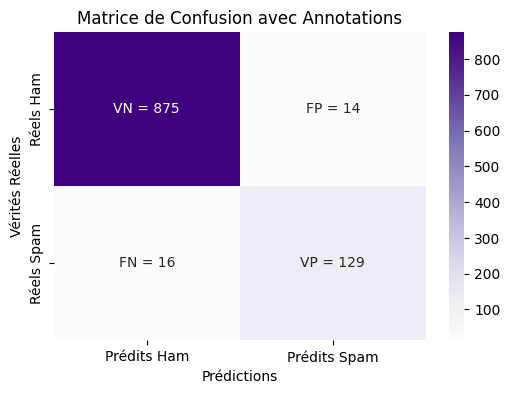

In [311]:
# Prédiction sur les données de test
y_pred = (model_rnn.predict(X_test) > 0.5).astype("int32")  # Prédiction binaire (0 ou 1)


# Génération de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# Définition des labels avec annotations explicites
labels = np.array([
    [f"VN = {cm[0, 0]}", f"FP = {cm[0, 1]}"],  
    [f"FN = {cm[1, 0]}", f"VP = {cm[1, 1]}"]
])

# Création de la heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=labels, fmt="", cmap="Purples", xticklabels=['Prédits Ham', 'Prédits Spam'], 
            yticklabels=['Réels Ham', 'Réels Spam'])

# Titres et labels
plt.xlabel("Prédictions")
plt.ylabel("Vérités Réelles")
plt.title("Matrice de Confusion avec Annotations")
plt.show()




##### Interprétation:

Vrais Négatifs (VN = 875) : 875 emails non spam ont été correctement classés comme "Ham".

Faux Positifs (FP = 14) : 14 emails non spam (Ham) ont été incorrectement détectés comme Spam.

Faux Négatifs (FN = 16) : 16 emails Spam ont été incorrectement classés comme Ham.

Vrais Positifs (VP = 129) : 129 emails Spam ont été correctement détectés comme Spam.

In [314]:
# Affichage du rapport de classification (Precision, Recall, F1-Score)
print("Rapport de Classification :")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Rapport de Classification :
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       889
        Spam       0.90      0.89      0.90       145

    accuracy                           0.97      1034
   macro avg       0.94      0.94      0.94      1034
weighted avg       0.97      0.97      0.97      1034



##### Interprétation des résultats
Très bonne performance globale :
Accuracy=0.97 → 97% des mails sont correctement classés.

Classe "Ham" presque parfaite :
98 % de précision, 98% de rappel → très peu de faux positifs ou faux négatifs pour "Ham".

Classe "Spam" bien détectée :
90 % de précision, 89 % de rappel → la majorité des spams sont capturés, avec quelques faux positifs (mails légitimes classés en spam) et quelques spams ratés.

F1-score :
"Ham" = 0.98
"Spam" = 0.90
Cela reflète la différence de difficulté entre détecter un "Ham" (classe majoritaire) et un "Spam" (moins fréquent).

Bien que le modèle affiche une bonne performance globale, il ne détecte pas parfaitement les spams, comme en témoigne un F1-score de 0,86 pour cette classe, indiquant qu'il reste des marges d'amélioration pour réduire les faux négatifs et optimiser la détection.

Améliorations possibles :
Optimisation du modèle : L'ajustement des hyperparamètres ou l'utilisation d'architectures comme LSTM/GRU pourrait améliorer la détection des "spam".

## **2.Modélisation avec LSTM & Mécanisme d’Attention**

**Creation et entraînement du model:**

In [283]:
# Paramètres du modèle
embedding_dim = 100
lstm_units = 64
max_len = max_length  # Longueur maximale des séquences

# Définir les entrées
inputs = Input(shape=(max_len,))

# Embedding Layer
embedding = Embedding(input_dim=5000, output_dim=embedding_dim)(inputs)

# LSTM Layer
lstm_output = LSTM(lstm_units, return_sequences=True)(embedding)

# Attention Layer - attention à la sortie de LSTM
attention_output = Attention()([lstm_output, lstm_output])  # Attention sur la même sortie (query = value)

flatten_output = Flatten()(attention_output)

# Dropout pour éviter le sur-apprentissage
dropout_output = Dropout(0.5)(flatten_output)

# Dense Layer pour la classification
dense_output = Dense(1, activation='sigmoid')(dropout_output)

# Créer le modèle
model_lstm = Model(inputs=inputs, outputs=dense_output)

# Compilation du modèle
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])


# Résumé du modèle
model_lstm.summary()

# Calcul des class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Entraîner le modèle
history = model_lstm.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, 
                          class_weight=class_weights, callbacks=[early_stopping])

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)   │ (None, 78)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_25 (Embedding)      │ (None, 78, 100)           │         500,000 │ input_layer_25[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_9 (LSTM)                 │ (None, 78, 64)            │          42,240 │ embedding_25[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_9 (Attention)       │ (None, 78, 64)            │               0 │ lstm_9[0][0], lstm_9[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_9 (Flatten)           │ (None, 4992)              │               0 │ attention_9[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_25 (Dropout)          │ (None, 4992)              │               0 │ flatten_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_25 (Dense)              │ (None, 1)                 │           4,993 │ dropout_25[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 547,233 (2.09 MB)

 Trainable params: 547,233 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.7137 - precision_25: 0.1519 - recall_25: 0.4367 - val_loss: 0.3329 - val_precision_25: 0.6746 - val_recall_25: 0.9551
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.2093 - precision_25: 0.8570 - recall_25: 0.9023 - val_loss: 0.0596 - val_precision_25: 0.9634 - val_recall_25: 0.8876
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1164 - precision_25: 0.9613 - recall_25: 0.9508 - val_loss: 0.0405 - val_precision_25: 0.9438 - val_recall_25: 0.9438
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0776 - precision_25: 0.9760 - recall_25: 0.9734 - val_loss: 0.0495 - val_precision_25: 0.9341 - val_recall_25: 0.9551
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0238 - precision_25: 0.9826 - recall_25: 0.9883 - val_loss: 0.0491 - val_precision_25: 0.9444 - val_recall_25: 0.9551
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0090 - precision_25: 0.9928 - re

**Prédiction et Évaluation du Modèle  📊**

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


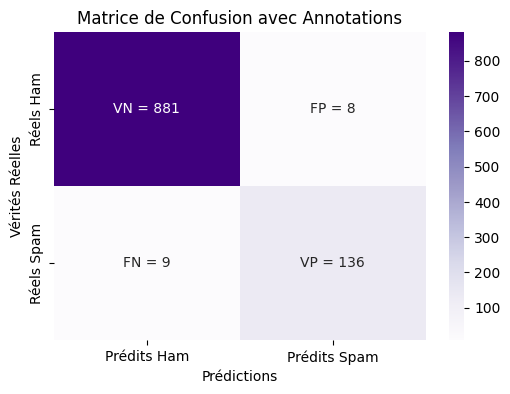

In [285]:
# Prédictions sur le jeu de test
y_pred = (model_lstm.predict(X_test) > 0.5).astype("int32")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Définition des labels avec annotations explicites
labels = np.array([
    [f"VN = {cm[0, 0]}", f"FP = {cm[0, 1]}"],  
    [f"FN = {cm[1, 0]}", f"VP = {cm[1, 1]}"]
])

# Création de la heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=labels, fmt="", cmap="Purples", xticklabels=['Prédits Ham', 'Prédits Spam'], 
            yticklabels=['Réels Ham', 'Réels Spam'])

# Titres et labels
plt.xlabel("Prédictions")
plt.ylabel("Vérités Réelles")
plt.title("Matrice de Confusion avec Annotations")
plt.show()

##### **Interprétation:**
Vrais Négatifs (VN = 881) : 881 emails non spam ont été correctement classés comme "Ham" (a augmenté par rapport a RNN)

Faux Positifs (FP = 8) : 8 emails non spam (Ham) ont été incorrectement détectés comme Spam (a diminué par rapport a RNN)

Faux Négatifs (FN=9) :9 emails Spam ont été incorrectement classés comme Ham (a diminué par rapport a RNN).

Vrais Positifs (VP= 136) :136 emails Spam ont été correctement détectés comme Spam (a augmenté par rapport a RNN)e Spam.

In [297]:
# Rapport de classification
report = classification_report(y_test, y_pred, target_names=["Ham", "Spam"])
print("Rapport de Classification :")
print(report)

Rapport de Classification :
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       889
        Spam       0.94      0.94      0.94       145

    accuracy                           0.98      1034
   macro avg       0.97      0.96      0.97      1034
weighted avg       0.98      0.98      0.98      1034



##### **Interprétation**
Classe "Ham" : Le modèle atteint des résultats quasi parfaits, avec un précision de 99 % et un rappel de 99 %, ce qui signifie qu'il détecte presque tous les emails légitimes sans faire d'erreurs.

Classe "Spam" : La détection des spams est également solide, avec une précision de 94 % et un rappel de 94 %, ce qui montre que le modèle identifie correctement la majorité des spams tout en réduisant les faux positifs.

Performance globale : L'accuracy de 98 % et les scores F1 élevés pour les deux classes montrent que le modèle est robuste et performant pour la classification des emails.


##### **Comparaison entre les resultats de RNN et LSTM**

In [259]:
import pandas as pd

# Data for comparison
data = {
    "Métrique": ["Précision (Ham)", "Rappel (Ham)", "F1-Score (Ham)",
                 "Précision (Spam)", "Rappel (Spam)", "F1-Score (Spam)",
                 "Exactitude"],
    "RNN": [0.98, 0.97, 0.98, 0.84, 0.88, 0.86, 0.96],
    "LSTM": [0.99, 0.99, 0.99, 0.94, 0.92, 0.93, 0.98]
}

# Creating a DataFrame
df_comparison = pd.DataFrame(data)

# Display the comparison table
df_comparison


,Métrique,RNN,LSTM
0,Précision (Ham),0.98,0.99
1,Rappel (Ham),0.97,0.99
2,F1-Score (Ham),0.98,0.99
3,Précision (Spam),0.84,0.94
4,Rappel (Spam),0.88,0.92
5,F1-Score (Spam),0.86,0.93
6,Exactitude,0.96,0.98


Le modèle LSTM surpasse globalement le modèle RNN dans tous les aspects :

-Meilleure précision, rappel et score F1 pour les deux classes ("Ham" et "Spam").

-Meilleure précision globale (accuracy), avec 98 % contre 96 % pour le RNN.

-Moins de faux positifs et de faux négatifs, ce qui améliore la robustesse du modèle.

### **Extraction et Visualisation des scores d’attention**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


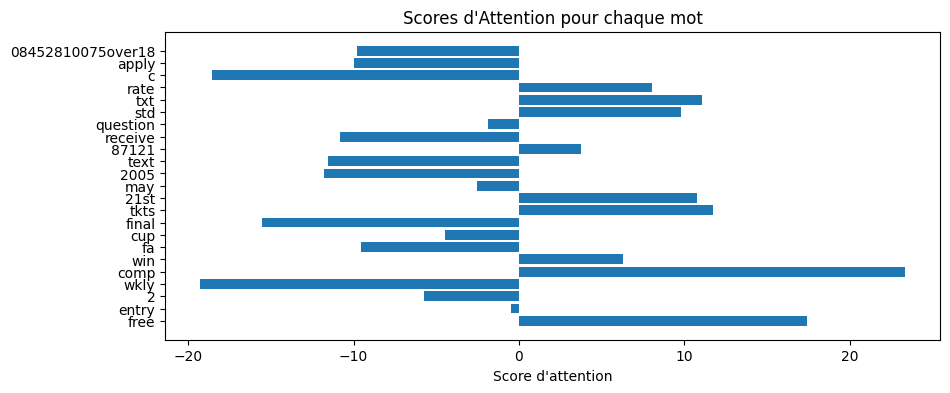

In [262]:
# Extraire les scores d'attention
attention_model = Model(inputs=inputs, outputs=attention_output)  # Le modèle pour obtenir les scores d'attention

# Choisir un échantillon à analyser (par exemple, la première séquence d'entrée)
sample_text = df['clean_text'].iloc[2]  # Remplacer par l'index du texte que tu veux analyser
sample_sequence = tokenizer.texts_to_sequences([sample_text])
sample_sequence_padded = pad_sequences(sample_sequence, maxlen=max_len, padding='post')

# Prédire les scores d'attention
attention_scores = attention_model.predict(sample_sequence_padded)

# Obtenir les scores d'attention pour chaque mot (somme des scores d'attention à travers les différentes positions)
attention_weights = np.sum(attention_scores[0], axis=0)

# Récupérer les mots correspondants aux indices, en excluant les padding (valeurs 0)
words = tokenizer.sequences_to_texts(sample_sequence_padded)[0].split()

# Filtrer les indices non nuls
non_padded_indices = [i for i, val in enumerate(sample_sequence_padded[0]) if val != 0]
filtered_attention_weights = [attention_weights[i] for i in non_padded_indices]
filtered_words = [words[i] for i in non_padded_indices]

# Mapper les mots et leur score d'attention
word_attention_map = {word: filtered_attention_weights[i] for i, word in enumerate(filtered_words)}

# Afficher la carte de chaleur des scores d'attention
plt.figure(figsize=(10, 4))
plt.barh(list(word_attention_map.keys()), list(word_attention_map.values()))
plt.xlabel('Score d\'attention')
plt.title('Scores d\'Attention pour chaque mot')
plt.savefig("Scores.png")
plt.show()


## **3.Modélisation avec Transformers**

Pour la modélisation avec Transformers, nous allons utiliser BERT (Bidirectional Encoder Representations from Transformers), un modèle de référence pour la classification de texte. Il'y a d'autres architectures comme GPT ou T5, mais BERT est particulièrement bien adapté à la classification des emails en spam ou ham.

Nous allons utiliser un tokenizer BERT pour transformer le texte en tokens adaptés au modèle.

**Creation et entraînement du model:**

In [110]:
df = df[['clean_text', 'label']]  # 'text' contient les emails, 'label' = 0 (ham) ou 1 (spam)

# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Fonction de tokenization
def tokenize_function(examples):
    return tokenizer(examples["clean_text"], padding="max_length", truncation=True,max_length=512)

# Convertir le dataframe en Dataset Hugging Face
dataset = Dataset.from_pandas(df)

# Tokenization des données
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["clean_text"])

# Split train/test
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)

Map:   0%|          | 0/5169 [00:00<?, ? examples/s]

In [111]:
from transformers import EarlyStoppingCallback

# Charger un modèle pré-entraîné pour la classification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Définition des arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",  # évaluer toutes les X steps
    eval_steps=50,  # par exemple, évaluer toutes les 50 itérations
    save_strategy="steps",
    per_device_train_batch_size=8,  # augmenter la taille si possible
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=200,
    load_best_model_at_end=True,
    fp16=False  # Désactivation car pas de GPU
)

# Trainer pour entraîner le modèle
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split["train"],
    eval_dataset=train_test_split["test"],
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # patience à ajuster selon vos besoins
)

# Entraînement
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1344\510777504.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
50,No log,0.153758
100,No log,0.081054
150,No log,0.064983
200,0.166400,0.072539
250,0.166400,0.075799
300,0.166400,0.063689
350,0.166400,0.065487
400,0.057500,0.063583
450,0.057500,0.064576
500,0.057500,0.066601


Could not locate the best model at ./results\checkpoint-400\pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=517, training_loss=0.09653327451222639, metrics={'train_runtime': 17065.5713, 'train_samples_per_second': 0.242, 'train_steps_per_second': 0.03, 'total_flos': 1087964213913600.0, 'train_loss': 0.09653327451222639, 'epoch': 1.0})

📉 training_loss = 0.0965
→ La perte d'entraînement est faible, ce qui signifie que le modèle apprend bien les données d'entraînement

**Prédiction et Évaluation du Modèle  📊**

In [113]:
# Évaluation
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.06657730787992477, 'eval_runtime': 621.2371, 'eval_samples_per_second': 1.664, 'eval_steps_per_second': 0.209, 'epoch': 1.0}


📉 eval_loss = 0.0665
→ La perte sur les données de validation est aussi faible.
Cela montre que le modèle généralise bien et ne surapprend pas (overfitting).

In [121]:
# Utilisez le trainer pour obtenir les prédictions sur le jeu de test
predictions = trainer.predict(train_test_split["test"])

# Les prédictions sont sous forme de logits, on prend l'argmax pour obtenir les classes prédites
y_pred = np.argmax(predictions.predictions, axis=1)

# Les étiquettes réelles sont dans predictions.label_ids
y_true = predictions.label_ids

# Affichage du rapport de classification
classification_report(y_true, y_pred, target_names=['Ham', 'Spam'])


              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       895
        Spam       0.98      0.93      0.95       139

    accuracy                           0.99      1034
   macro avg       0.98      0.96      0.97      1034
weighted avg       0.99      0.99      0.99      1034



 Notre modèle offre une précision exceptionnelle (99%) avec un excellent équilibre entre précision et rappel, faisant de lui notre meilleur modèle pour détecter les emails spam et ham !